# Comparing samples with matched distributions of stellar mass

In this notebook we use the subsamples of bplanck galaxies with mass distributions matched to COSMOS to measure lensing

- most of the cells at the beginning are the same as in `dwarf_lensing.ipynb` to load halotools and measure lensing
- [Skip to matched distribution section](#matched_distribution)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
import matplotlib.pyplot as plt

import halotools
from halotools.mock_observables import total_mass_enclosed_per_cylinder


## Read in from cache 

In [5]:
#The halo catalog is now stored in cache and can be loaded into memory at any time
from halotools.sim_manager import HaloTableCache, CachedHaloCatalog
cache = HaloTableCache()

#list cache entries
for entry in cache.log: 
    print(entry) 
    
#read in halocat    
halocat = CachedHaloCatalog(simname = simname, halo_finder = halo_finder, 
                            version_name = version_name, redshift = z_sim, ptcl_version_name=ptcl_version_name) # doctest: +SKIP

print(halocat.redshift) # doctest: +SKIP
print(halocat.ptcl_version_name) # doctest: +SKIP



('bolplanck', 'rockstar', 'halotools_v0p4', '0.4966', '/Users/fardila/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_0.66818.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', '/Users/fardila/.astropy/cache/halotools/halo_catalogs/bolshoi/rockstar/hlist_1.00035.list.halotools_v0p4.hdf5')
('bolshoi-planck', 'rockstar', 'bplanck_dwarfs', '0.2786', '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/bplanck/hlist_0.78209.hdf5')
0.2786
bplanck_dwarfs


To delete an entry from the log, you can either use the `remove_entry_from_cache_log` method of the HaloTableCache class, or equivalently, you can manually delete line #"+str(linenum)+"from the log file. [source](https://halotools.readthedocs.io/en/latest/_modules/halotools/sim_manager/rockstar_hlist_reader.html)
The log file is stored in the following location:

In [12]:
cache.cache_log_fname

u'/Users/fardila/.astropy/cache/halotools/halo_table_cache_log.txt'

## abundance match with variable scatter

In [80]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
model = PrebuiltSubhaloModelFactory('behroozi10', redshift=z_sim, 
                                    scatter_abscissa=[12, 15], scatter_ordinates=[0.4, 0.2])
model.populate_mock(halocat)
print(model.mock.galaxy_table[0:9])

halo_upid  halo_hostid     halo_mpeak    ...    vz    galid  stellar_mass
---------- ----------- ----------------- ... -------- ----- -------------
        -1  2404371171 162700000000000.0 ...  -118.07     0 57583608000.0
2404371171  2404371171      6819000000.0 ...   484.04     1     30324.178
2404371171  2404371171      5889000000.0 ...  -214.14     2      765049.4
2404371171  2404371171      5734000000.0 ...  -795.51     3     75578.555
2404371171  2404371171      3254000000.0 ...  -213.05     4     7263.4336
2404371171  2404371171     73760000000.0 ... -1119.11     5    65690684.0
2404371171  2404371171      1085000000.0 ...  -633.85     6      13534.91
2404371171  2404371171      4959000000.0 ...  1374.05     7     493738.28
2404371171  2404371171       929800000.0 ...  -591.06     8     22774.309


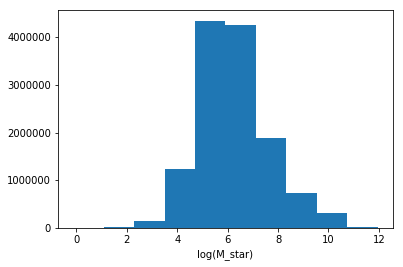

In [10]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.xlabel('log(M_star)')
plt.show()

In [11]:
model.param_dict
#model._haloprop_list

{u'scatter_model_param1': 0.4,
 u'scatter_model_param2': 0.2,
 u'smhm_beta_0': 0.43,
 u'smhm_beta_a': 0.18,
 u'smhm_delta_0': 0.56,
 u'smhm_delta_a': 0.18,
 u'smhm_gamma_0': 1.54,
 u'smhm_gamma_a': 2.52,
 u'smhm_m0_0': 10.72,
 u'smhm_m0_a': 0.59,
 u'smhm_m1_0': 12.35,
 u'smhm_m1_a': 0.3}

In [81]:
#calculate smf
#Bolshoi volume was 250h^(-1)Mpc on each side https://www.cosmosim.org/cms/simulations/bolshoip/

M     = model.mock.galaxy_table['stellar_mass']         #Read stellar masses
logM  = np.log10(M)                     #Take logarithm
nbins = 100                             #Number of bins to divide data into
V     = (250/0.7)**3                    #Survey volume in Mpc3
Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
dM    = edg[1] - edg[0]                 #Bin size
centers   = edg[0:-1] + dM/2.           #Mass axis
Phi   = Phi / float(V) / dM             #Normalize to volume and bin size
logPhi= np.log10(Phi)


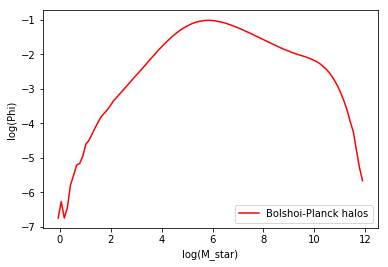

In [13]:
plt.plot(centers,logPhi, c='r', label='Bolshoi-Planck halos')
plt.xlabel('log(M_star)')
plt.ylabel('log(Phi)')
plt.legend()
plt.show()

# Compute the lensing

* Read in the DM particles, x, y,z (manually)
* Precompute the lensing
* Then compute the lensing for the model above (plot the model Delta Sigma verus R)
* Then compare the lensing with the data

catalog from this paper: [Laigle et al. 2016](http://adsabs.harvard.edu/abs/2016ApJS..224...24L)

## read in DM particle positions

In [69]:
from astropy.table import Table

ptcl_table = Table.read('Data/bplanck/bplanck_particles_100m_a0.78209.hdf5', path='data')

px = ptcl_table['x']
py = ptcl_table['y']
pz = ptcl_table['z']
particles = np.vstack((px, py, pz)).T

## read in galaxy positions

In [82]:
x = model.mock.galaxy_table['x']
y = model.mock.galaxy_table['y']
z = model.mock.galaxy_table['z']
galaxies = np.vstack((x, y, z)).T

In [83]:
print len(galaxies)
print len(particles)

12939617
99993334


### Make cut in mass

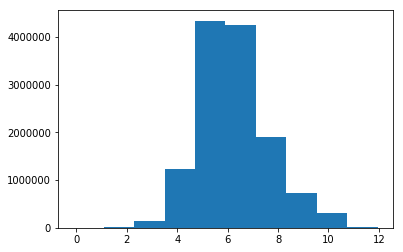

In [18]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.show()

In [84]:
galaxies_table=model.mock.galaxy_table[np.log10(model.mock.galaxy_table['stellar_mass'])>10]

In [20]:
len(galaxies_table)

170298

### read in again with mass cut

In [85]:
x = galaxies_table['x']
y = galaxies_table['y']
z = galaxies_table['z']
galaxies = np.vstack((x, y, z)).T

# precompute lensing


### downsample

In [86]:
from halotools.utils import randomly_downsample_data
num_ptcls_to_use = int(1e4)
particles = randomly_downsample_data(particles, num_ptcls_to_use)
particle_masses = np.zeros(num_ptcls_to_use) + halocat.particle_mass

#need to account for the fact that you are not using the entire snapshot of particles by providing the downsampling_factor argument:
halocat.num_ptcl_per_dim=2048 #for bolshoi-planck : https://github.com/astropy/halotools/blob/master/halotools/sim_manager/supported_sims.py
total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(particles))

#same bins as data
rp_bins = np.logspace(-2, 0, 9)
# range = [0.01,1.0] #Correlation range
# nbins = 8 #Number of bins

period = model.mock.Lbox    
    

### calculate the mass enclosed by the cylinders around each galaxy

In [87]:
mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins, period)

#create mask for centrals
# cenmask = model.mock.galaxy_table['gal_type'] == 'centrals'
# cens = galaxies[cenmask]
# mass_encl_cens = mass_encl[cenmask, :]


In [88]:
#cosmology
from astropy.cosmology import LambdaCDM
H0=67.8
Om0=0.307
Ode0=0.693

halocat.cosmology = LambdaCDM(H0, Om0, Ode0)

In [89]:
h_sim = halocat.cosmology.H(0).value/100.
print h_sim

0.678


### delta sigma

In [90]:
from halotools.mock_observables import delta_sigma_from_precomputed_pairs
rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2

## plot

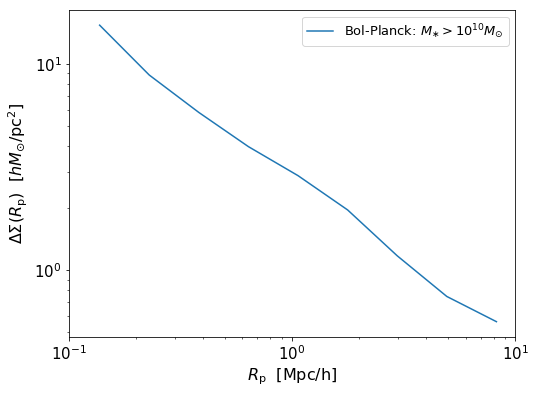

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

__=plt.loglog()

__=ax.plot(rp, ds, label=r'Bol-Planck: $M_{\ast} > 10^{10}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

__=ax.set_xlim(xmin = 0.1, xmax = 10)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)


plt.show()

## compare with data

Will get distribution of masses from data (COSMOS dwarf galaxies) and match that distribution in simulation galaxies, then use that catalog to calculate lensing signal. Then use MCMC to match lensing signal to measured lensing signal of dwarf galaxies.

Laigle2015 Cosmolgy: H0 = 67.8, Omega_M = 0.307, Omega_L = 0.693.

In [4]:
#lensing signal 
lensing_signal_file = '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/dwarf_all_lens_laigle2015_nozp2.out'
dwarf_sample_file = '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/dwarf_sample_for_paper.fits'

In [5]:
cosmos_lensing_signal = ascii.read(lensing_signal_file)
print cosmos_lensing_signal

  R(Mpc)  SigR(Msun/pc^2) err(weights) ... Nsources    <R>        e2    
--------- --------------- ------------ ... -------- --------- ----------
0.0133352      58.8677431   17.3327507 ...     2176 0.0142079 -5.3672735
0.0237137      11.8954158    9.6261485 ...     7082 0.0250451 13.2385548
0.0421697       5.6647874    5.4522923 ...    22133 0.0446207  3.5197639
0.0749894       3.2644803    3.0599847 ...    70223 0.0791256  1.1381985
0.1333521       3.9288803    1.7389203 ...   217526 0.1406552 -2.5727109
0.2371374       3.5901829    0.9840321 ...   679967 0.2502264  1.6006856
0.4216965       1.4727592    0.5573089 ...  2120184 0.4446665 -0.0681996
0.7498942       2.5547892    0.3172553 ...  6543536 0.7906795 -0.2700844


In [29]:
cosmos_lensing_signal.colnames

['R(Mpc)',
 'SigR(Msun/pc^2)',
 'err(weights)',
 'err(resampling)',
 'Nsources',
 '<R>',
 'e2']

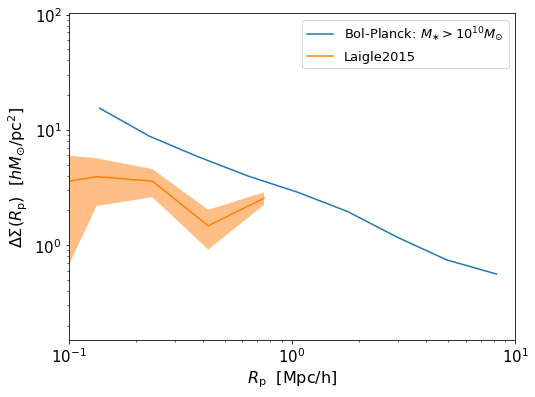

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

__=plt.loglog()

__=ax.plot(rp, ds, label=r'Bol-Planck: $M_{\ast} > 10^{10}M_{\odot}$')
ax.fill_between(rp, ds,ds, alpha=0.5)
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

ax.plot(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'], label=r'Laigle2015')
ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
                cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

__=ax.set_xlim(xmin = 0.1, xmax = 10)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)


plt.show()

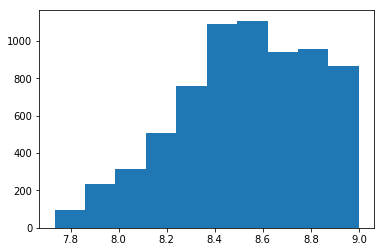

In [33]:
plt.hist(dwarf_masses)
plt.show()

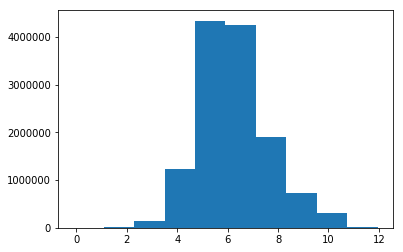

In [34]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.show()

## Create sample with same distribution of $M_*$ as dwarf sample <a id='matched_distribution'></a>

In [35]:
print len(dwarf_masses)
print min(dwarf_masses), max(dwarf_masses)

6876
7.73324 8.99998


1190936


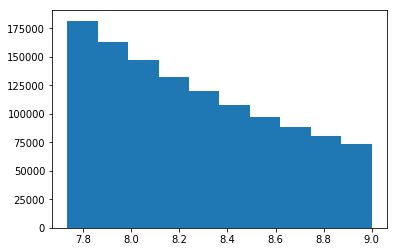

In [36]:
#galaxy table limited to mass range of dwarfs
mock_galaxies = model.mock.galaxy_table
mock_galaxies = mock_galaxies['galid', 'x', 'y', 'z', 'stellar_mass']
mock_galaxies = mock_galaxies[(np.log10(mock_galaxies['stellar_mass'])>=min(dwarf_masses)) & (np.log10(mock_galaxies['stellar_mass'])<9.0)]

print len(mock_galaxies)
plt.hist(np.log10(mock_galaxies['stellar_mass']))
plt.show()

### done in separate script 

In [63]:
#read in dwarf catalog
dwarf_galaxies_50 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_50.npy')
dwarf_galaxies_30 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_30.npy')
dwarf_galaxies_10 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_10.npy')
dwarf_galaxies_5 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_5.npy')
dwarf_galaxies_1 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_1.npy')

In [64]:
RP=[]
DS=[]

In [96]:
rp_bins+0.03415

array([0.04415   , 0.05193279, 0.06577278, 0.09038413, 0.13415   ,
       0.21197794, 0.35037777, 0.59649133, 1.03415   ])

In [67]:
for dwarf_galaxies in [dwarf_galaxies_5, dwarf_galaxies_10, dwarf_galaxies_30, dwarf_galaxies_50]:
    print len(dwarf_galaxies)
    
    x = [gal[1] for gal in dwarf_galaxies]
    y = [gal[2] for gal in dwarf_galaxies]
    z = [gal[3] for gal in dwarf_galaxies]
    galaxies = np.vstack((x, y, z)).T
    
    mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins+0.03415, period)

    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
    ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2
    
    RP.append(rp)
    DS.append(ds)

34380


NameError: name 'particles' is not defined

In [149]:
np.arange(3)**2

array([0, 1, 4])

In [7]:
def annular_area_weighted_midpoints(rp_bins):
    r""" Calculate the radius that bisects the areas a set of circles.

    Parameters
    ----------
    rp_bins : array_like
        Array of shape (num_circles, ) defining the input circles

    Returns
    -------
    rp_mids : array_like
        Array of shape (num_circles-1, ) defining the radii of annuli
        that subtend equal areas.

    Examples
    ---------
    >>> r_mids = annular_area_weighted_midpoints(np.linspace(0.1, 5, 10))
    """
    return np.sqrt(0.5*(rp_bins[:-1]**2 + rp_bins[1:]**2))


not possible to calculate the reverse because of gained entropy

In [109]:
annular_area_weighted_midpoints(rp_bins+(10**0.03415))

array([1.09570584, 1.10653195, 1.12580324, 1.160131  , 1.22134159,
       1.33063598, 1.52606162, 1.87578624])

In [108]:
annular_area_weighted_midpoints(rp_bins)

array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
       0.2565373 , 0.45619501, 0.81124219])

In [79]:
rp_bins

array([0.01      , 0.01778279, 0.03162278, 0.05623413, 0.1       ,
       0.17782794, 0.31622777, 0.56234133, 1.        ])

In [98]:
RP

[array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219]),
 array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219]),
 array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219]),
 array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219])]

In [74]:
cosmos_lensing_signal['R(Mpc)']

0.0133352
0.0237137
0.0421697
0.0749894
0.1333521
0.2371374
0.4216965
0.7498942


In [82]:
np.log10(rp - cosmos_lensing_signal['R(Mpc)'])

-2.9621940608101105
-2.7121914665488647
-2.4622060133879935
-2.212198280205067
-1.9621980417018086
-1.7122004210262984
-1.462199718946781
-1.2121996960421895


In [86]:
for i in range(len(rp)-1):
    print np.log10(rp[i+1]) - np.log10(rp[i])

0.25
0.2500000000000002
0.24999999999999978
0.2500000000000001
0.25
0.24999999999999994
0.25


In [87]:
for i in range(len(cosmos_lensing_signal['R(Mpc)']) -1):
    print np.log10(cosmos_lensing_signal['R(Mpc)'][i+1]) - np.log10(cosmos_lensing_signal['R(Mpc)'][i])

0.2499997877627953
0.25000119006307386
0.24999936736102835
0.24999998048824723
0.2500001946500353
0.24999994256373265
0.2499999981262017


In [90]:
print np.log10(cosmos_lensing_signal['R(Mpc)']) - np.log10(rp)
print 'mean: ', np.mean(np.log10(cosmos_lensing_signal['R(Mpc)']) - np.log10(rp))

        R(Mpc)       
---------------------
 -0.03415099262097887
 -0.03415120485818357
 -0.03415001479510993
 -0.03415064743408136
 -0.03415066694583424
 -0.03415047229579893
-0.034150529732066226
-0.034150531605864565
mean:  -0.03415063253598971


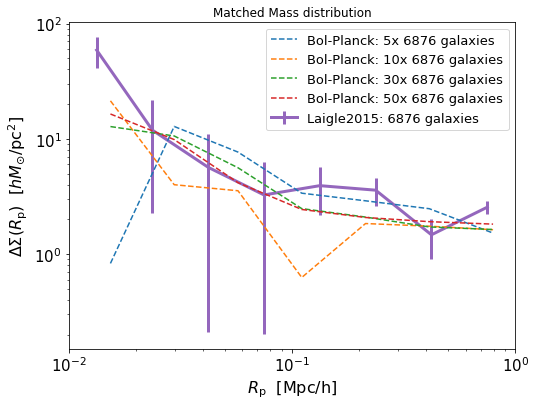

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.loglog()

for rp, ds, n in zip(RP,DS, [5,10,30,50]):
    ax.plot(rp, ds, label=r'Bol-Planck: ' +str(n)+ 'x '+str(len(dwarf_masses))+' galaxies', linestyle='--', zorder=3)
    ax.fill_between(rp, ds,ds, alpha=0.5)
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

ax.errorbar(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'], yerr=cosmos_lensing_signal['err(weights)'],
            label=r'Laigle2015: ' +str(len(dwarf_masses))+ ' galaxies', linewidth=3, zorder=1)
# ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
#                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

__=ax.set_xlim(xmin = 0.01, xmax = 1)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.title('Matched Mass distribution')
plt.show()

In [91]:
dwarf_galaxies = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_50.npy')

In [102]:
array = reverse_annular_area_weighted_midpoints(cosmos_lensing_signal['R(Mpc)'], 0.01, 1.0)

In [99]:
x = [gal[1] for gal in dwarf_galaxies]
y = [gal[2] for gal in dwarf_galaxies]
z = [gal[3] for gal in dwarf_galaxies]
galaxies = np.vstack((x, y, z)).T

mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor,
                                             array, period)

rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, array, period, cosmology=halocat.cosmology)
ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2


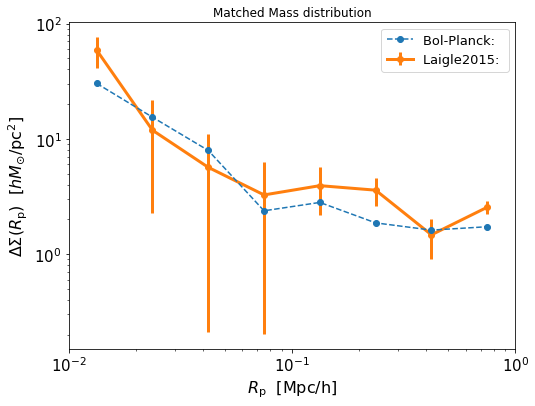

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.loglog()


ax.plot(rp, ds, label=r'Bol-Planck: ', linestyle='--', zorder=3, marker='o')
ax.fill_between(rp, ds,ds, alpha=0.5)
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

ax.errorbar(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'],
            yerr=cosmos_lensing_signal['err(weights)'], marker='o', label=r'Laigle2015: ', linewidth=3, zorder=1)
# ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
#                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

__=ax.set_xlim(xmin = 0.01, xmax = 1)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.title('Matched Mass distribution')
plt.show()

## histogram

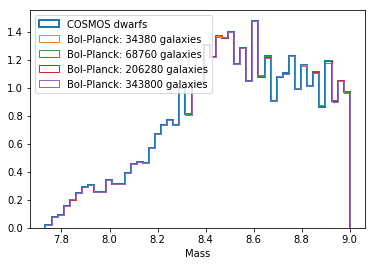

In [61]:

plt.hist(dwarf_masses, bins=50, histtype='step', normed=True, linewidth=2, label='COSMOS dwarfs')
for dwarf_galaxies in [dwarf_galaxies_5, dwarf_galaxies_10, dwarf_galaxies_30, dwarf_galaxies_50]:
    mock_masses = [np.log10(d[-1]) for d in dwarf_galaxies]
    plt.hist(mock_masses, bins=50, histtype='step', normed=True, label=r'Bol-Planck: ' +str(len(dwarf_galaxies))+ ' galaxies')
    
plt.xlabel('Mass')
plt.legend(loc='upper left')
plt.show()

# file for Alexie

In [118]:
rp_bins = np.logspace(-2, 1.3, 20)

In [119]:
dwarf_galaxies = dwarf_galaxies_50
print len(dwarf_galaxies)

x = [gal[1] for gal in dwarf_galaxies]
y = [gal[2] for gal in dwarf_galaxies]
z = [gal[3] for gal in dwarf_galaxies]
galaxies = np.vstack((x, y, z)).T

mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins, period)

rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2

343800


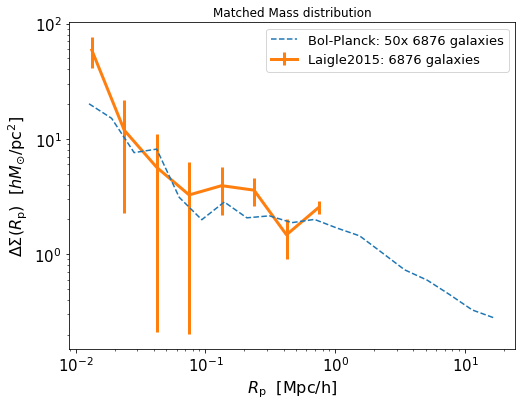

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.loglog()

ax.plot(rp, ds, label=r'Bol-Planck: ' +str(n)+ 'x '+str(len(dwarf_masses))+' galaxies', linestyle='--', zorder=3)
# ax.fill_between(rp, ds,ds, alpha=0.5)

ax.errorbar(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'], yerr=cosmos_lensing_signal['err(weights)'],
            label=r'Laigle2015: ' +str(len(dwarf_masses))+ ' galaxies', linewidth=3, zorder=1)
# ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
#                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

# __=ax.set_xlim(xmin = 0.01, xmax = 1)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.title('Matched Mass distribution')
plt.show()

In [124]:
from astropy.table import Table, Column
data = Table([rp, ds], names=['r', 'DS'])
ascii.write(data, 'BolPlanck_r_DS_50.txt')

a) Take my bins and do : my_bin * (1+z)*h and use that as an input for halo tools. Use the redshift of the mock.

b) when you get the result from halo tools, convert back to my units

c) Also need to convert delta sigma to the same units.
ds_phys_real_h = ds_comov_h_inverse * (1+REDSHIFT)^2*h*1e-12;

# convert bins 

In [155]:
rp_bins_physical_no_h = np.logspace(-2, 0, 9)
rp_bins_comoving_h = np.logspace(-2, 0, 9)*(1+z_sim)/h_sim
print rp_bins_physical_no_h
print rp_bins_comoving_h

[0.01       0.01778279 0.03162278 0.05623413 0.1        0.17782794
 0.31622777 0.56234133 1.        ]
[0.01885841 0.03353552 0.05963552 0.10604862 0.18858407 0.33535517
 0.59635519 1.06048616 1.88584071]


In [165]:
arr = 10**(np.log10(rp_bins_physical_no_h ) - 0.03415063253598971)
print arr

[0.00924378 0.01643801 0.02923138 0.05198157 0.09243775 0.16438015
 0.29231383 0.51981567 0.9243775 ]


In [170]:
print 10**(-0.03415063253598971)
print 10**(0.03415063253598971)

0.924377503325
1.08180910548


In [174]:
(1+z_sim)#/h_sim

1.2786

In [166]:
print annular_area_weighted_midpoints(arr)
print (annular_area_weighted_midpoints(rp_bins_comoving_h)/(1+z_sim))*h_sim
print cosmos_lensing_signal['R(Mpc)']

[0.01333521 0.02371373 0.04216964 0.0749894  0.13335211 0.23713731
 0.4216964  0.74989403]
[0.01442615 0.02565373 0.0456195  0.08112422 0.14426153 0.2565373
 0.45619501 0.81124219]
  R(Mpc) 
---------
0.0133352
0.0237137
0.0421697
0.0749894
0.1333521
0.2371374
0.4216965
0.7498942


In [175]:
cosmos_lensing_signal


R(Mpc),SigR(Msun/pc^2),err(weights),err(resampling),Nsources,<R>,e2
float64,float64,float64,float64,int64,float64,float64
0.0133352,58.8677431,17.3327507,21.7752764,2176,0.0142079,-5.3672735
0.0237137,11.8954158,9.6261485,14.8534154,7082,0.0250451,13.2385548
0.0421697,5.6647874,5.4522923,12.2597098,22133,0.0446207,3.5197639
0.0749894,3.2644803,3.0599847,5.3533424,70223,0.0791256,1.1381985
0.1333521,3.9288803,1.7389203,2.2541496,217526,0.1406552,-2.5727109
0.2371374,3.5901829,0.9840321,1.5130009,679967,0.2502264,1.6006856
0.4216965,1.4727592,0.5573089,1.1298721,2120184,0.4446665,-0.0681996
0.7498942,2.5547892,0.3172553,0.8907857,6543536,0.7906795,-0.2700844


9/21/18:
Can't figure out the bins with h or z, but if I simply subtract 0.034 in log space it works out.

### reverse engineer 

In [ ]:
np.sqrt(0.5*(rp_bins[:-1]**2 + rp_bins[1:]**2))

In [49]:
def reverse_annular_area_weighted_midpoints(bins, initial, final):
    array = [initial]
    new_entry = initial
    
    for b in bins:
        new_entry = np.sqrt(2*(b**2) - (new_entry**2))
        array.append(new_entry)
        
    array.append(final)
    
    return np.array(array)[:-1]

In [61]:
array = reverse_annular_area_weighted_midpoints(cosmos_lensing_signal['R(Mpc)'], 0.01, 1.0)
print array
print np.log10(array)

[0.01       0.01598922 0.02947921 0.05184152 0.09251636 0.1643359
 0.29233885 0.51980176 0.92438561]
[-2.         -1.79617275 -1.53048411 -1.28532227 -1.03378146 -0.78426755
 -0.53411346 -0.28416225 -0.03414683]


from [Kobayashi et al. 2015](http://adsabs.harvard.edu/abs/2015MNRAS.449.2128K) `radial binning scheme is arbitrary – we opt to make 451 bins with logarithmically equal width from 0.013 to 419 kpc` 

In [58]:
np.logspace(np.log10(0.013), np.log10(419), 451)

array([1.30000000e-02, 1.33033719e-02, 1.36138233e-02, 1.39315196e-02,
       1.42566297e-02, 1.45893267e-02, 1.49297876e-02, 1.52781935e-02,
       1.56347300e-02, 1.59995868e-02, 1.63729579e-02, 1.67550421e-02,
       1.71460428e-02, 1.75461680e-02, 1.79556306e-02, 1.83746486e-02,
       1.88034448e-02, 1.92422477e-02, 1.96912905e-02, 2.01508123e-02,
       2.06210577e-02, 2.11022769e-02, 2.15947259e-02, 2.20986669e-02,
       2.26143680e-02, 2.31421036e-02, 2.36821547e-02, 2.42348085e-02,
       2.48003592e-02, 2.53791078e-02, 2.59713623e-02, 2.65774378e-02,
       2.71976568e-02, 2.78323494e-02, 2.84818534e-02, 2.91465145e-02,
       2.98266863e-02, 3.05227307e-02, 3.12350183e-02, 3.19639280e-02,
       3.27098478e-02, 3.34731746e-02, 3.42543146e-02, 3.50536835e-02,
       3.58717067e-02, 3.67088196e-02, 3.75654676e-02, 3.84421065e-02,
       3.93392030e-02, 4.02572344e-02, 4.11966893e-02, 4.21580675e-02,
       4.31418808e-02, 4.41486526e-02, 4.51789187e-02, 4.62332275e-02,
      

In [43]:
cosmos_lensing_signal['R(Mpc)']

0.0133352
0.0237137
0.0421697
0.0749894
0.1333521
0.2371374
0.4216965
0.7498942


In [62]:
for i, a in enumerate(np.log10(array)):
    print a - np.log10(array[i+1])

-0.20382724574749655
-0.26568864387886393
-0.24516183561661964
-0.2515408166597415
-0.2495139062966465
-0.2501540901615742
-0.24995120862974346
-0.25001542790500525


IndexError: index 9 is out of bounds for axis 0 with size 9

In [32]:
annular_area_weighted_midpoints(array)

array([0.0133352, 0.0237137, 0.0421697, 0.0749894, 0.1333521, 0.2371374,
       0.4216965, 0.7498942])

In [12]:
cosmos_lensing_signal['R(Mpc)']

0.0133352
0.0237137
0.0421697
0.0749894
0.1333521
0.2371374
0.4216965
0.7498942
